In [34]:
import numpy as np
import scipy
import scipy.ndimage
import matplotlib.patches 
import h5py
import matplotlib
import matplotlib.pyplot as mpl
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import sys
import os
import copy

import os.path

In [35]:
pwd

'/Users/olofjonsson/Projects/Ice_peak_shape3/Bragg-CDI-ice-analysis-master/examples'

In [36]:
#f = h5py.File("../../output_r0144/type1/LCLS_2011_Feb28_r0144_163006_2feb_cspad.h5", 'r')
f = h5py.File("../../output_r0144/type1/LCLS_2011_Feb28_r0144_163548_1149_cspad.h5", 'r')
d = f['data/data'][:]
wavelength = f['LCLS/photon_wavelength_A'][0]/1e10
detector_distance = f['LCLS/detectorPosition'][0]/1000
pixel_size = 109.92*1e-6

In [37]:
# calculate qx, qy
image = d
center = None
x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
xx, yy = np.meshgrid(x, y)
if center is None:
    xx = xx.astype(np.float64) - (image.shape[1]-1)/2
    yy = yy.astype(np.float64) - (image.shape[0]-1)/2
else:
    xx -= center[1]
    yy -= center[0]
rad = np.sqrt(xx*xx + yy*yy)
qx = 2.*np.pi*2.*np.sin(0.5*np.arctan2(xx*pixel_size, detector_distance))/(wavelength)
qy = 2.*np.pi*2.*np.sin(0.5*np.arctan2(yy*pixel_size, detector_distance))/(wavelength)

In [38]:
threshold = (np.mean(image)+np.std(image))

"\n#BELOW IS A TEST FOR GAUSSIAN FILTER TO BROADEN PEAKS BEFORE LABELING\n\n\nimage_thresholded = np.copy(image)\n\nconvoluted=scipy.ndimage.gaussian_filter(image_thresholded,10,order=0)\n\nthreshold = (np.mean(convoluted)+np.std(convoluted))\n\nimage_thresholded[convoluted<threshold] = 0\n\ncmap=copy.copy(mpl.cm.viridis)\ncmap.set_bad(color='white',alpha=1)\n\nplt.figure(dpi=300)\nplt.imshow(np.ma.masked_where(image_thresholded == 0, image_thresholded),cmap=cmap,origin='lower')\nplt.colorbar()\n\nlabeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded,structure=structuring_element)\npeak_regions = scipy.ndimage.find_objects(labeled_image)\n#plt.figure(dpi=300)\n#plt.imshow(image_thresholded,cmap='viridis',origin='lower')\n"

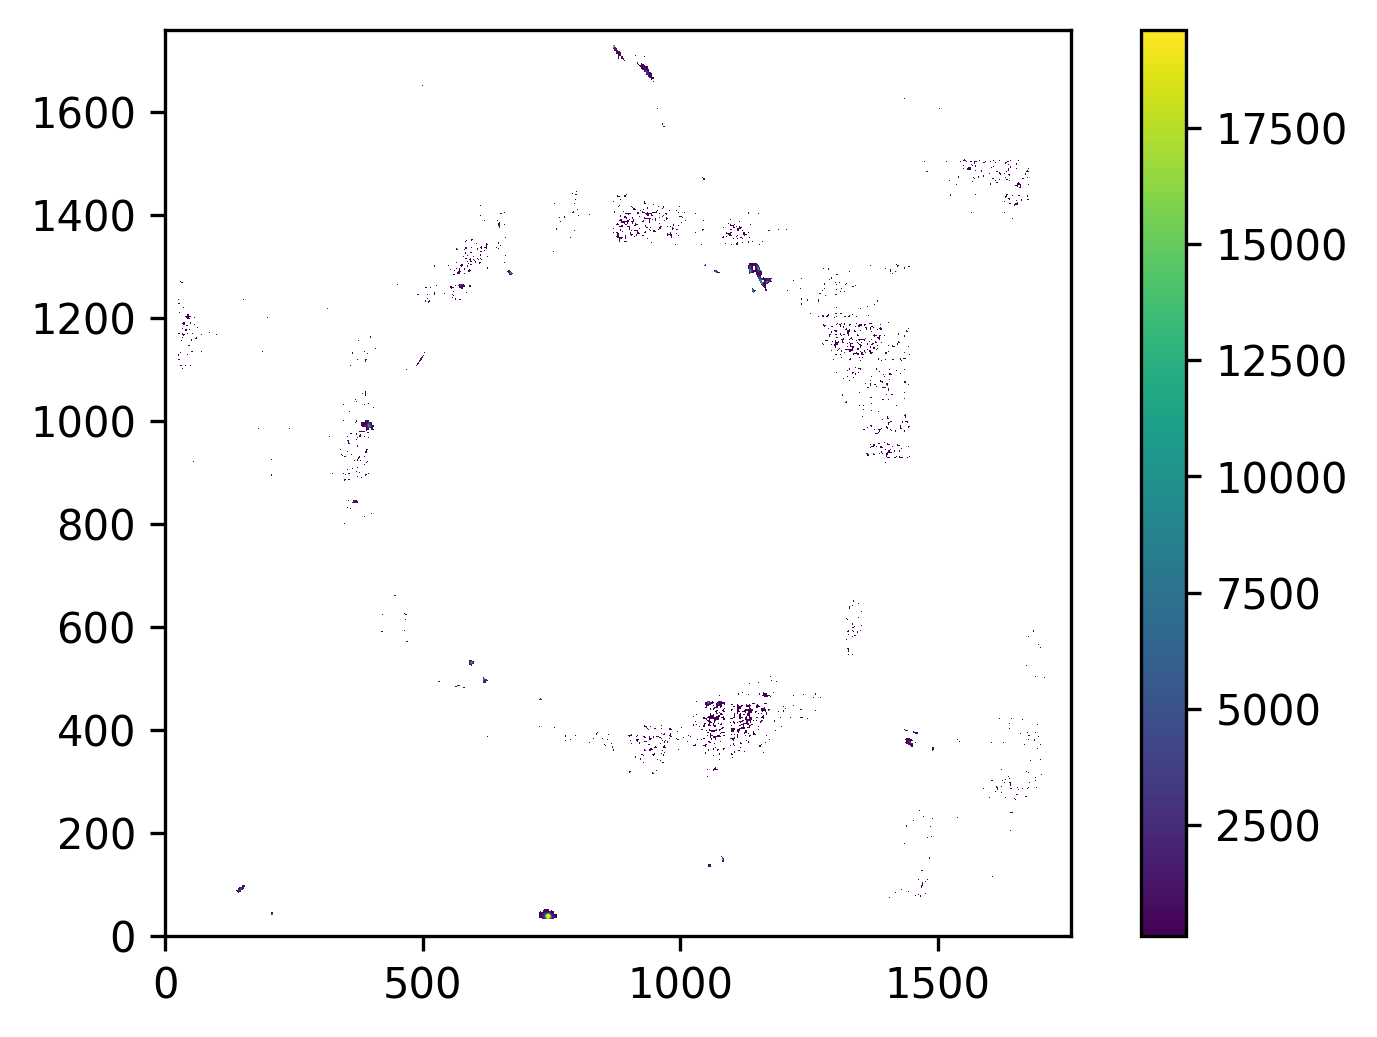

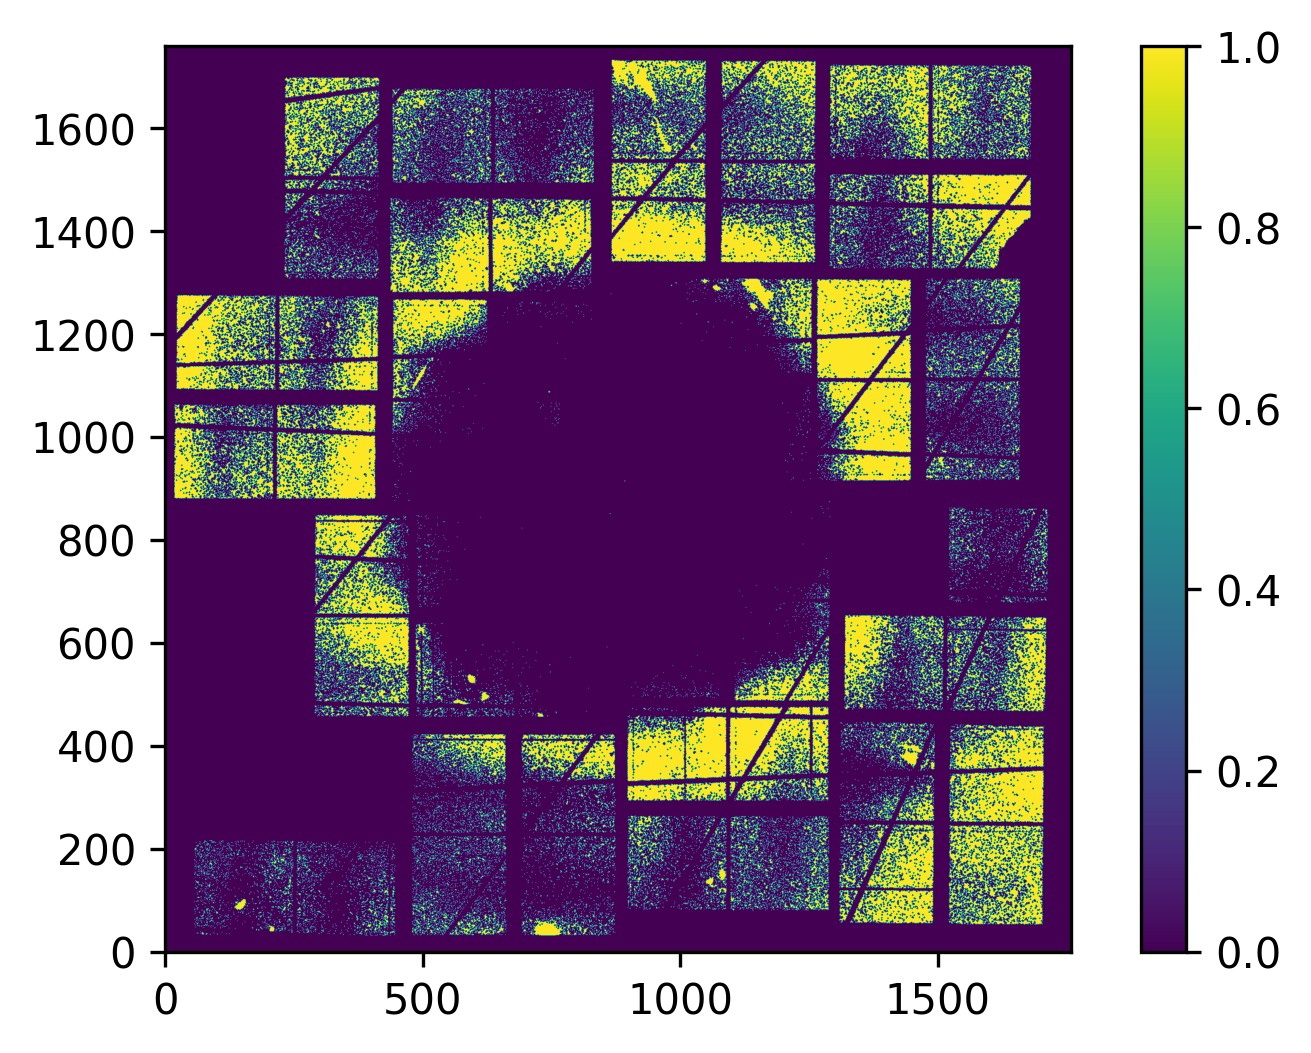

In [117]:
structuring_element=[[0,1,0],
                      [1,1,1],
                      [0,1,0]]

structuring_element=np.ones([3,3])



# method 2 thresholding the whole image and set everything below threshold equal to zero
## find peak regions based on the value of the threshold
image_thresholded = np.copy(image)
image_thresholded[image<threshold] = 0


cmap=copy.copy(mpl.cm.viridis)
cmap.set_bad(color='white',alpha=1)



#image_thresholded[~(image_thresholded % 7).astype(bool)] = np.nan

plt.figure(dpi=300)
plt.imshow(np.ma.masked_where(image_thresholded == 0, image_thresholded),cmap=cmap,origin='lower')
plt.colorbar()

#find the peak regions and label all the pixels
labeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded,structure=structuring_element)
peak_regions = scipy.ndimage.find_objects(labeled_image)


#BELOW IS A TEST FOR EROSION

iterations=1

dilated=scipy.ndimage.binary_dilation(image_thresholded,iterations=iterations)
eroded=scipy.ndimage.binary_erosion(dilated,iterations=iterations)


image_thresholded=eroded

plt.figure(dpi=300)
plt.imshow(eroded,cmap=cmap,origin='lower')
plt.colorbar()

#plt.figure(dpi=300)
#plt.imshow(np.ma.masked_where(image_thresholded == 0, image_thresholded),cmap=cmap,origin='lower')
#plt.colorbar()

#find the peak regions and label all the pixels
labeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded,structure=structuring_element)
peak_regions = scipy.ndimage.find_objects(labeled_image)


'''
#BELOW IS A TEST FOR GAUSSIAN FILTER TO BROADEN PEAKS BEFORE LABELING


image_thresholded = np.copy(image)

convoluted=scipy.ndimage.gaussian_filter(image_thresholded,10,order=0)

threshold = (np.mean(convoluted)+np.std(convoluted))

image_thresholded[convoluted<threshold] = 0

cmap=copy.copy(mpl.cm.viridis)
cmap.set_bad(color='white',alpha=1)

plt.figure(dpi=300)
plt.imshow(np.ma.masked_where(image_thresholded == 0, image_thresholded),cmap=cmap,origin='lower')
plt.colorbar()

labeled_image, number_of_peaks = scipy.ndimage.label(image_thresholded,structure=structuring_element)
peak_regions = scipy.ndimage.find_objects(labeled_image)
#plt.figure(dpi=300)
#plt.imshow(image_thresholded,cmap='viridis',origin='lower')
'''

In [110]:
peak_list = []
centroid_list = []
for peak_region_i in peak_regions:
    if d[peak_region_i].shape[0]>15 and d[peak_region_i].shape[1]>15:
        cx = np.sum(d[peak_region_i]*qx[peak_region_i])/np.sum(d[peak_region_i])
        cy = np.sum(d[peak_region_i]*qy[peak_region_i])/np.sum(d[peak_region_i])
        peak_list.append(d[peak_region_i])
        centroid_list.append((cx,cy))

<ipython-input-111-e184135ca450>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


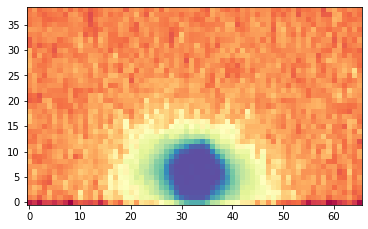

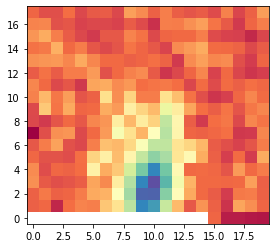

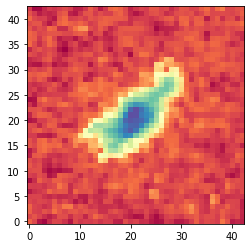

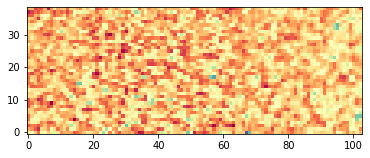

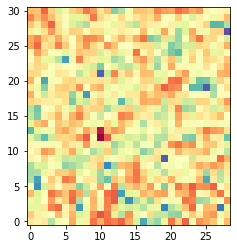

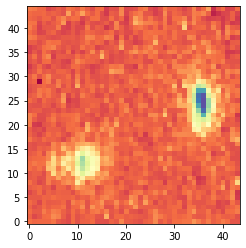

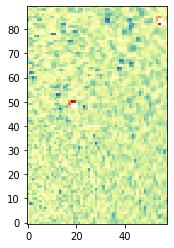

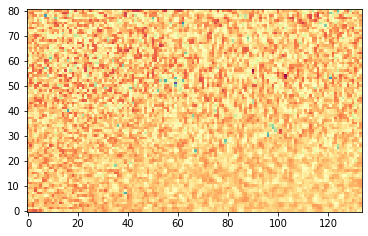

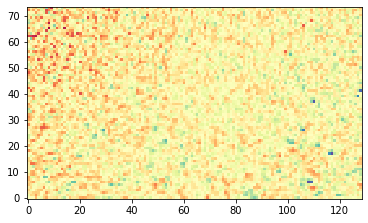

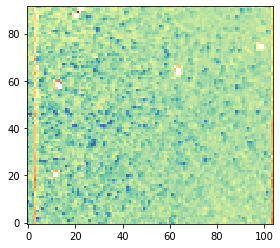

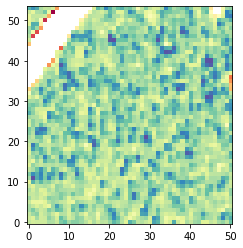

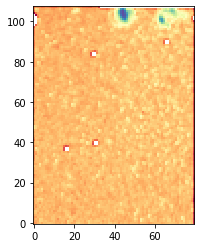

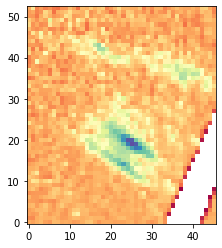

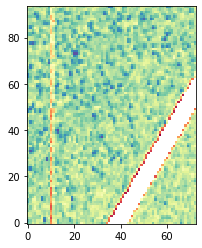

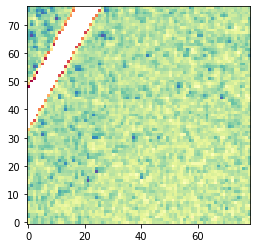

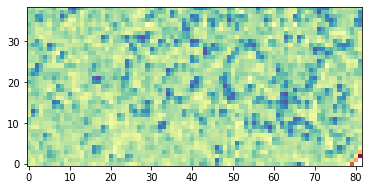

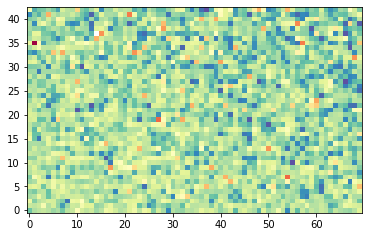

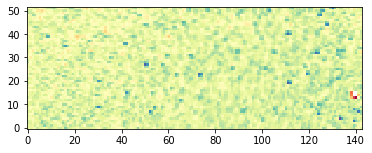

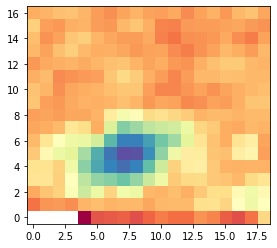

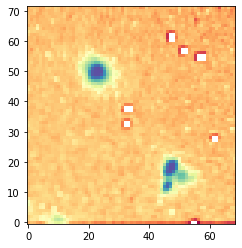

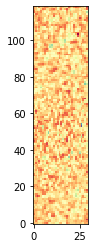

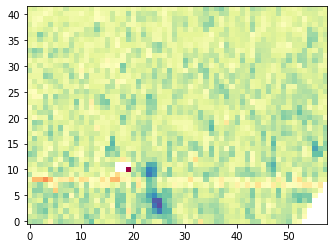

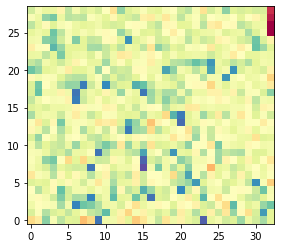

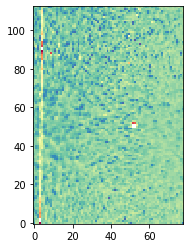

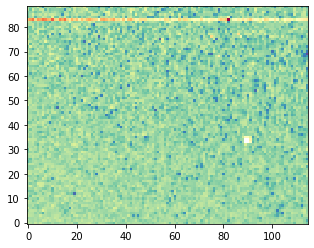

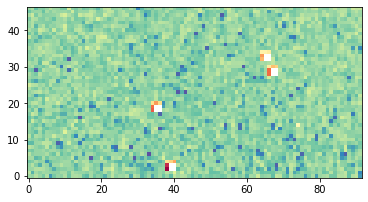

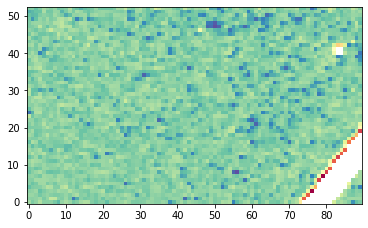

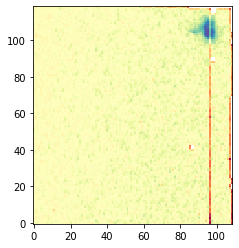

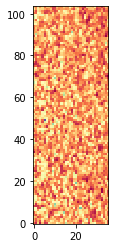

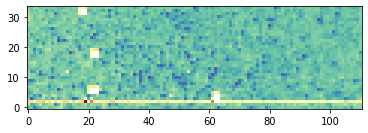

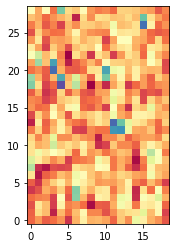

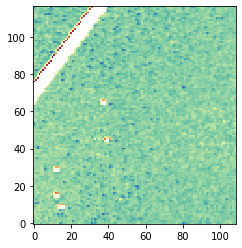

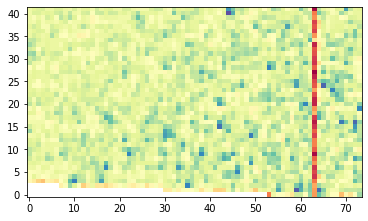

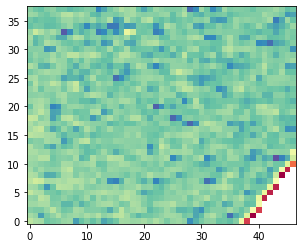

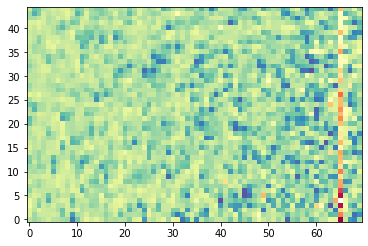

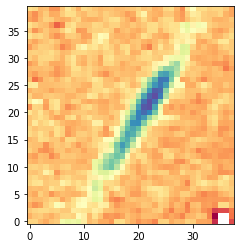

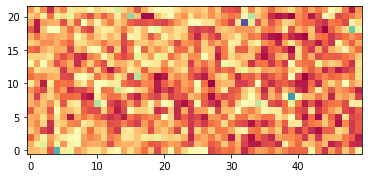

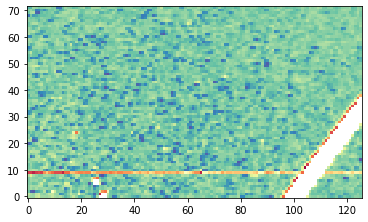

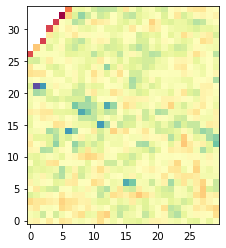

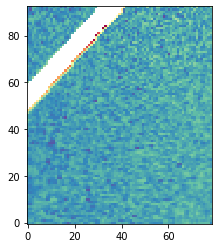

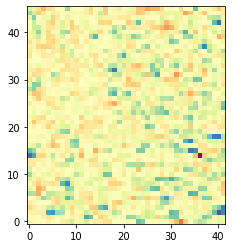

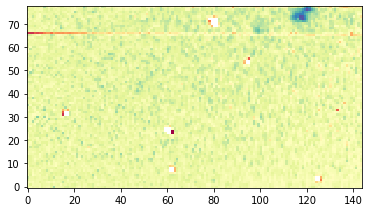

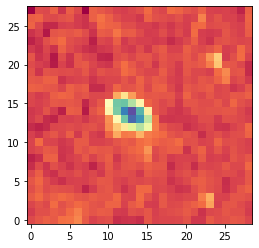

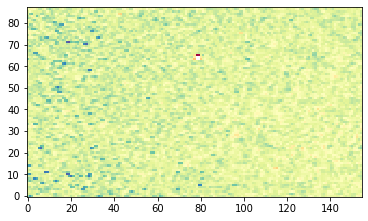

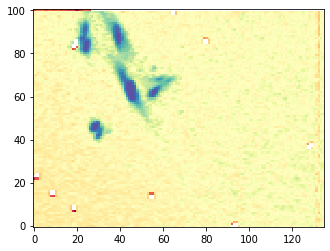

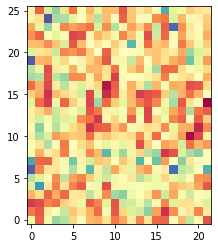

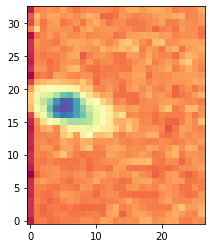

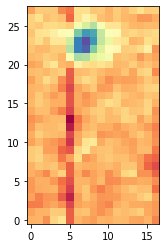

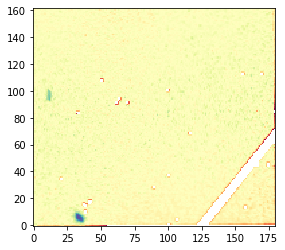

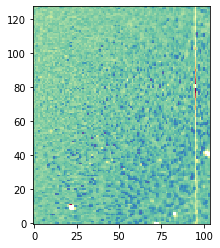

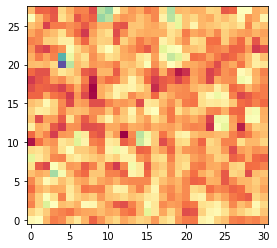

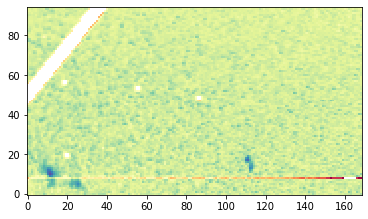

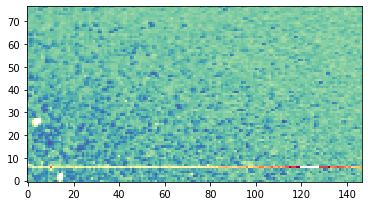

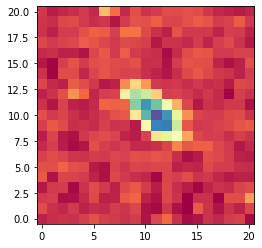

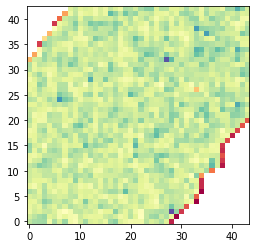

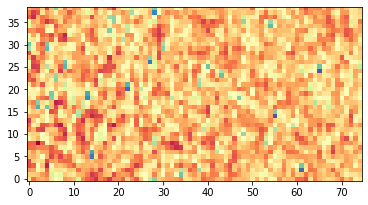

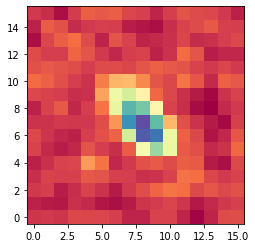

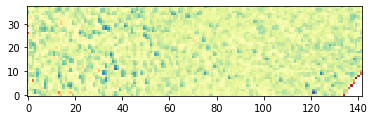

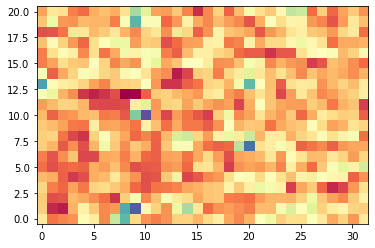

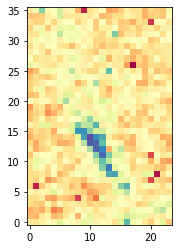

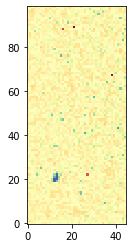

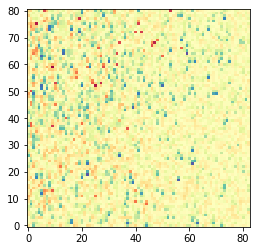

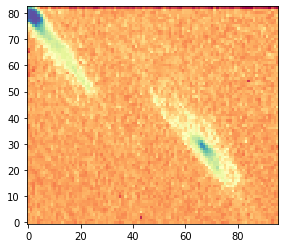

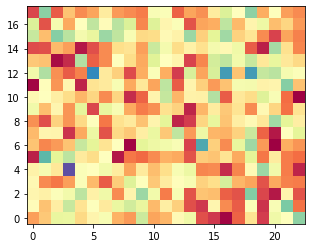

In [111]:
vmin=None#threshold#np.min(image)
vmax=None#np.max(image)#threshold#np.max(image)

plt.close('all')
for i in range(len(peak_list)):
    plt.figure()
    plt.imshow(peak_list[i],vmin=vmin, vmax=vmax,interpolation='none', origin='lower', cmap=plt.get_cmap('Spectral'),norm=colors.LogNorm())
    #plt.savefig('../../Tests/Peaks/diagonal_{0}.png'.format(i))

In [112]:
pic=plt.imread('/Users/olofjonsson/Pictures/Olof_Jönsson.jpg')[:,:,0]

In [99]:

convoluted=scipy.ndimage.gaussian_filter(pic,sigma=10,order=1)

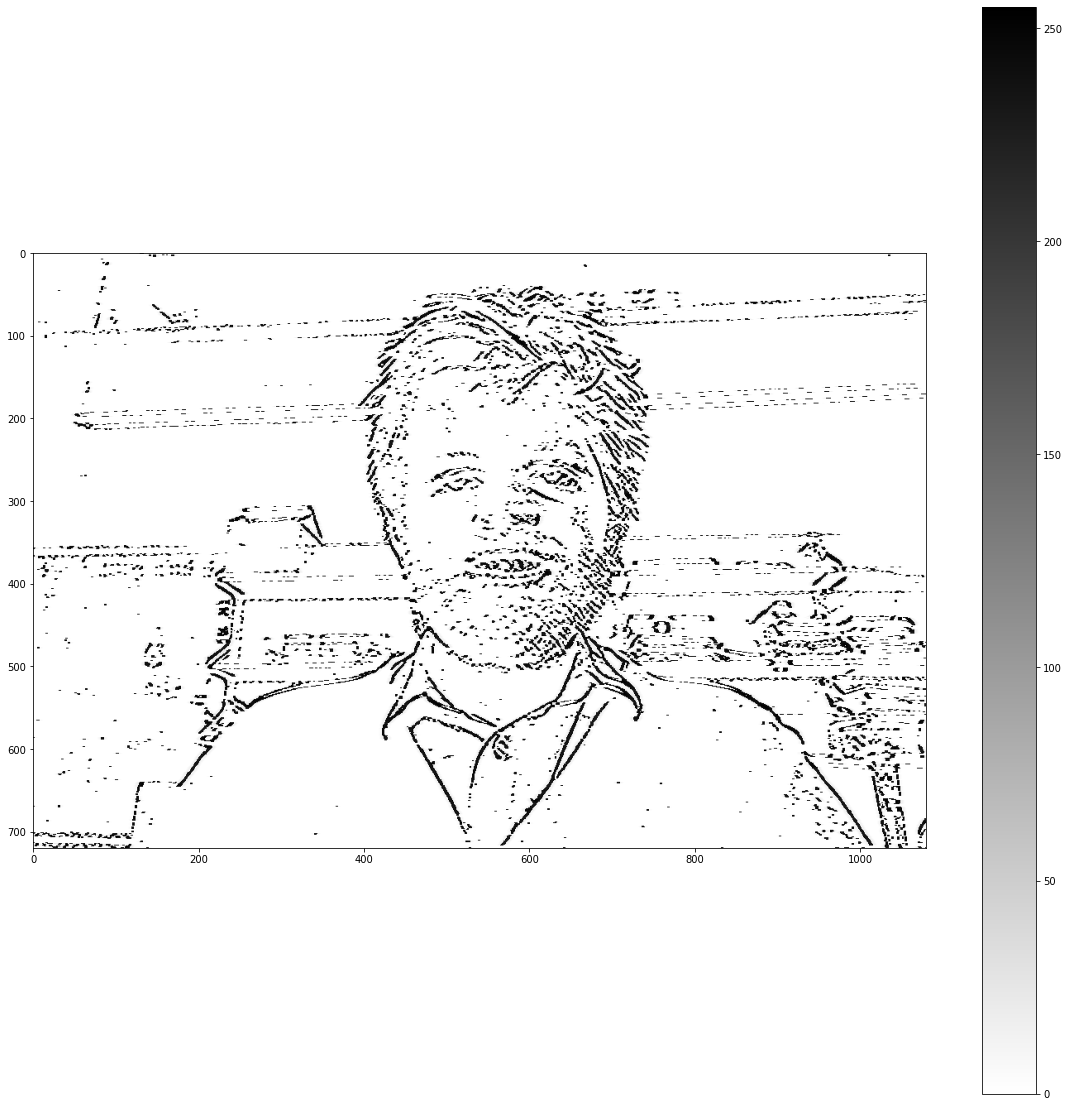

In [135]:
convoluted=scipy.ndimage.gaussian_filter(pic,sigma=2,order=2)
plt.figure(figsize=[20,20])
plt.imshow(convoluted,cmap='gray_r')
plt.colorbar()